In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Vahadane implementation
import os

def rgb_to_od(image):
    assert image.dtype == np.uint8

    OD = -np.log((image.astype(np.float32) + 1) / 255.0)
    return OD

def normalize_matrix_cols(A):
    return A / np.linalg.norm(A, axis=0)[None, :]

class VahadaneStainDeconvolution:
    def __init__(
        self,
        optical_density_threshold=0.15,
        sparsity_regularizer=1.0,
        regularizer_lasso=0.01,
        background_intensity=245, # FIXME: fit background
        stain_matrix_target_od=np.array(
            [[0.5626, 0.2159], [0.7201, 0.8012], [0.4062, 0.5581]]
        ),
        max_c_target=np.array([1.9705, 1.0308])
    ) -> None:
        self.optical_density_threshold = optical_density_threshold
        self.sparsity_regularizer = sparsity_regularizer
        self.regularizer_lasso = regularizer_lasso
        self.background_intensity = background_intensity
        self.stain_matrix_target_od = stain_matrix_target_od
        self.max_c_target = max_c_target

    def fit(self, image):
        stain_matrix = self._estimate_stain_vectors(image)

        C = self._estimate_pixel_concentrations(
            image=image, stain_matrix=stain_matrix
        )

        max_C = np.percentile(C, 99, axis=0).reshape((1, 2))

        self.stain_matrix_target_od = stain_matrix
        self.max_c_target = max_C

    def _estimate_stain_vectors(self, image):
        import spams

        image_od = rgb_to_od(image)
        image_od = image_od.reshape((-1, 3))
        OD = image_od[np.all(image_od > self.optical_density_threshold, axis=1)]

        os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
        dictionary = spams.trainDL(
            X=OD.T,
            K=2,
            lambda1=self.sparsity_regularizer,
            mode=2,
            modeD=0,
            posAlpha=True,
            posD=True,
            verbose=False
        )
        dictionary = normalize_matrix_cols(dictionary)
        if dictionary[0, 1] > dictionary[0, 0]:
            dictionary = dictionary[:, [1, 0]]
        return dictionary

    def _estimate_pixel_concentrations(self, image, stain_matrix):
        import spams

        image_OD = rgb_to_od(image).reshape((-1, 3))
        lamb = self.regularizer_lasso
        C = (
            spams.lasso(X=image_OD.T, D=stain_matrix, mode=2, lambda1=lamb, pos=True)
            .toarray()
            .T
        )
        return C

    def _reconstruct_image(self, pixel_intensities, kind):
        max_c = np.percentile(pixel_intensities, 99, axis=0).reshape((1, 2))
        pixel_intensities *= self.max_c_target / max_c

        im = np.exp(
            -self.stain_matrix_target_od[:, kind].reshape((-1, 1))
            @ pixel_intensities[:, kind].reshape((-1, 1)).T
        )

        im *= self.background_intensity
        im = np.clip(im, a_min=0, a_max=255)
        im = im.T.astype(np.uint8)
        return im

    def F(self, image, method):
        stain_matrix = self._estimate_stain_vectors(image=image)
        C = self._estimate_pixel_concentrations(image, stain_matrix)

        im_reconstructed = self._reconstruct_image(
            pixel_intensities=C,
            kind={'hematoxylin': 0, 'eosin': 1}[method.lower()]
        )
        return im_reconstructed.reshape(image.shape)

# Pipelines

In [6]:
# Hematoxylin deconvolution
def vahadane(sparsity_regularizer):
    vahadane_transform = VahadaneStainDeconvolution(sparsity_regularizer=sparsity_regularizer)
    def deconvolute_hematoxylin(image):
        return vahadane_transform.F(image=image, method='hematoxylin')
    return deconvolute_hematoxylin

In [7]:
# Enhance contrast
from skimage.exposure import equalize_adapthist  # Just import the name

In [8]:
# Convert to inverted gray-scale image
def inverted_gray_scale(image):
    from skimage.color import rgb2gray
    image_gray = rgb2gray(image)
    image_gray_inverted = 1 - image_gray
    image_gray_inverted = (image_gray_inverted * 255).astype(np.uint8)
    return image_gray_inverted

In [9]:
from skimage.filters import threshold_otsu

In [10]:
from skimage.morphology import remove_small_objects

In [11]:
from skimage.morphology import remove_small_holes

In [12]:
from scipy.ndimage import distance_transform_edt

In [13]:
from skimage.feature import peak_local_max

In [14]:
def peaks_to_markers(peaks, shape):
    from skimage.measure import label
    mask = np.zeros(shape, dtype=bool)
    mask[tuple(peaks.T)] = True
    markers = label(mask)
    return markers

In [15]:
from skimage.segmentation import watershed

In [45]:
def merge_small_labels(labelled_mask, min_size, verbose = True):
    """Merge labels less than threshold size
    Small labels are merged to their largest neighbor in order to
    discourage over-segmentation.
    Label sizes are dynamically monitored to prevent labels
    that become sufficiently large from merging from unnecessary
    merging

    Author: Ruihong Yuan
    """
    from skimage.measure import regionprops
    from skimage.segmentation import find_boundaries
    from skimage.morphology import dilation, square

    labels = labelled_mask.copy()

    label_areas = []
    small_labels = []
    for region in regionprops(labels, cache=False):
        area = region.area
        label_areas.append(area)
        if area < min_size:
            small_labels.append(region.label)

    merged_count = 0
    skipped_count = 0
    for label in small_labels:
        assert label_areas[label-1] != 0, "Label area is zero only when it has been merged"

        if label_areas[label-1] >= min_size:
            skipped_count += 1
            if verbose:
                print("Skipped", label, "because it has reached min_size after merging")
            continue

        # Find neighboring pixels (label boundary)
        label_boundaries = find_boundaries(labels == label)
        # Expand boundary for robustness
        expanded_boundaries = dilation(label_boundaries, square(3))

        # Collect label types of the boundary pixels
        neighbors = set(labels[expanded_boundaries].flat)
        # Remove background and this label
        neighbors.discard(0)
        neighbors.discard(label)

        if neighbors:
            # Find the largest neighbor label
            largest_neighbor = max(neighbors, key=lambda x: label_areas[x - 1])
            if verbose:
                print("Merged", label, "to", largest_neighbor)
            labels[labels == label] = largest_neighbor
            # Update label areas
            label_areas[largest_neighbor - 1] += label_areas[label - 1]
            label_areas[label - 1] = 0
            merged_count += 1

    if verbose:
        print("Total merged:", merged_count)
        print("Total skipped:", skipped_count)
    return labels

In [46]:
# The complete pipeline
def pipeline(input_image, params):
    vahadane_transform = vahadane(**params['vahadane'])

    image_H = vahadane_transform(input_image)
    image_H = equalize_adapthist(image_H, **params['equalize_adapthist'])
    image_H = inverted_gray_scale(image_H)
    nuclei = image_H > threshold_otsu(image_H)
    nuclei = remove_small_objects(nuclei, **params['remove_small_objects'])
    nuclei = remove_small_holes(nuclei, **params['remove_small_holes'])

    distances = distance_transform_edt(nuclei)
    local_maxima_idx = peak_local_max(distances, **params['peak_local_max'])
    markers = peaks_to_markers(local_maxima_idx, shape=nuclei.shape)
    labeled_nuclei = watershed(-distances, markers, mask=nuclei)
    labeled_nuclei = merge_small_labels(labeled_nuclei, **params['merge_small_labels'])
    return nuclei, labeled_nuclei

In [47]:
# Adjustable parameters
adjustable_params = {
    'vahadane:sparsity_regularizer': 0.8,
    'equalize_adapthist:clip_limit': 0.1,
    'remove_small_objects:min_size': 200,
    'remove_small_holes:area_threshold': 100,
    'peak_local_max': {
        'min_distance': 10,
        'footprint': np.ones((10, 10)),
        # This parameter causes loss of detected cells!
        # `merge_small_labels` already takes good care of over-segmentation
        # 'threshold_rel': None,
    },
    'merge_small_labels': {
        'min_size': 300,
        'verbose': True
    }
}

# Augment adjustable params
params = adjustable_params.copy()
for k, v in adjustable_params.items():
    try:
        method, param_name = k.split(sep=':')
        params.setdefault(method, dict())[param_name] = v
    except:
        pass

    if isinstance(v, dict):
        for k2, v2 in v.items():
            params[f"{k}:{k2}"] = v2
adjustable_params.update(params)
del params

print(adjustable_params)

{'vahadane:sparsity_regularizer': 0.8, 'equalize_adapthist:clip_limit': 0.1, 'remove_small_objects:min_size': 200, 'remove_small_holes:area_threshold': 100, 'peak_local_max': {'min_distance': 10, 'footprint': array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])}, 'merge_small_labels': {'min_size': 300, 'verbose': True}, 'vahadane': {'sparsity_regularizer': 0.8}, 'equalize_adapthist': {'clip_limit': 0.1}, 'remove_small_objects': {'min_size': 200}, 'remove_small_holes': {'area_threshold': 100}, 'peak_local_max:min_distance': 10, 'peak_local_max:footprint': a

In [48]:
from skimage.io import imread, imsave  # RGB instead of BGR (no need to convert)
from skimage.color import label2rgb

IMAGE_FILENAME = R"\SOB_M_MC-14-16456-400-038.png"
IMAGE_PATH = R"C:\Users\canch\Downloads\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\malignant\SOB\mucinous_carcinoma\SOB_M_MC_14-16456\400X"
MASK_PATH = IMAGE_PATH

image = imread(IMAGE_PATH + IMAGE_FILENAME)
mask, labeled_mask = pipeline(input_image=image, params=adjustable_params)
imsave(MASK_PATH + IMAGE_FILENAME.replace('.png', '_mask.png'), (label2rgb(label=labeled_mask) * 255).astype(np.uint8))

Merged 3 to 9
Merged 5 to 9
Merged 8 to 9
Merged 10 to 9
Merged 11 to 16
Merged 12 to 9
Merged 17 to 9
Merged 18 to 9
Merged 19 to 35
Merged 20 to 40
Merged 22 to 9
Merged 23 to 16
Merged 24 to 40
Merged 25 to 9
Merged 28 to 9
Merged 31 to 9
Merged 32 to 16
Merged 33 to 9
Merged 36 to 9
Merged 38 to 15
Merged 44 to 40
Merged 46 to 34
Merged 48 to 35
Merged 51 to 54
Merged 52 to 35
Merged 54 to 47
Merged 56 to 77
Merged 61 to 47
Merged 62 to 74
Merged 63 to 77
Merged 64 to 53
Merged 67 to 77
Merged 70 to 60
Merged 71 to 75
Merged 76 to 75
Merged 78 to 69
Merged 79 to 83
Merged 80 to 75
Merged 81 to 69
Merged 82 to 77
Merged 83 to 84
Skipped 84 because it has reached min_size after merging
Merged 85 to 99
Merged 88 to 93
Merged 89 to 90
Skipped 93 because it has reached min_size after merging
Merged 95 to 90
Merged 96 to 107
Merged 98 to 99
Merged 100 to 113
Merged 101 to 99
Merged 102 to 99
Merged 103 to 120
Merged 104 to 90
Merged 105 to 99
Merged 109 to 120
Merged 110 to 135
Merged 11

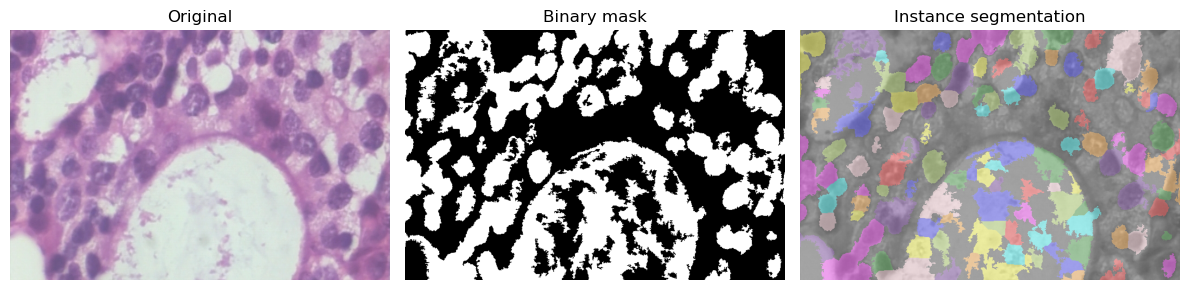

In [50]:
# Visualization
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
for ax in axes.ravel():
    ax.axis('off')

axes[0].imshow(image)
axes[0].set_title('Original')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Binary mask')

axes[2].imshow(label2rgb(label=labeled_mask, image=image))
axes[2].set_title('Instance segmentation')

plt.tight_layout()
plt.show()